# Prob of Emergence for Mask Model


$P(\text{Node wears mask}) = m$


$E_{L, 0}$ := Following an edge, the probability of extinction at level $L$ given the node wears a mask


$E_{L, 1}$ := Following an edge, the probability of extinction at level $L$ given the node doesn't wear a mask



## 1. Condition on num of neighbors


$B_k$ := Node v has $k - 1$ lower level neighbors

$P(E_{L, i}) = \sum_{k = 0}^{\infty}{P(E_{L, i} | B_k) * P(B_k)}$


$P(B_k) = \frac{k p_{k}}{\langle k\rangle}$



## 2. Condition on num of neighbors wearing a mask

$N$ := Num of neighbors wearing masks 
 
$N \sim \operatorname{Binomial}\left(k - 1, m\right)$


$ P(E_{L, i} | B_k) = \sum_{n = 0}^{k - 1} P(E_{L, i} | B_k, N = n) * \left(\begin{array}{c}
k - 1 \\
n
\end{array}\right) * m^{n} * (1 - m)^{k - 1 - n} $



## 3. Condition on num of infections

$I_0$ := $I_0$ of $n$ lower level neighbors who wear masks are active

$I_1$ := $I_1$ of $k-1-n$ lower level neighbors who don't wear masks are active



### Inital infective wears a mask

$I_0 \sim \operatorname{Binomial}\left(n, T_2)\right)$

$I_1 \sim \operatorname{Binomial}\left(k - 1 - n, T_1)\right)$


$P(E_{L, 0} | B_k, N = n) $

$= \sum_{k_0 = 0}^{n}\sum_{k_1 = 0}^{k - 1 - n}P(E_{L, i} | B_k, N = n, I_0 = k_0, I_1 = k_1) * \left(\begin{array}{c}
n \\
k_0
\end{array}\right)  * T_2 ^{k_0} * (1 - T_2)^{n - k_0} * \left(\begin{array}{c}
k - 1 - n \\
k_1
\end{array}\right) * T_1 ^{k_1} * (1 - T_1)^{k - 1 - n - k_1}$

$= \sum_{k_0 = 0}^{n}\sum_{k_1 = 0}^{k - 1 - n}\left(\begin{array}{c}
n \\
k_0
\end{array}\right)  * T_2 ^{k_0} * (1 - T_2)^{n - k_0} * \left(\begin{array}{c}
k - 1 - n \\
k_1
\end{array}\right) * T_1 ^{k_1} * (1 - T_1)^{k - 1 - n - k_1} * P(E_{L,0})^{k_0} * P(E_{L, 1})^{k_1}$
 
--- 

### Inital infective doesn't wear a mask

$I_0 \sim \operatorname{Binomial}\left(n, T_4)\right)$

$I_1 \sim \operatorname{Binomial}\left(k - 1 - n, T_3)\right)$


$P(E_{L, 1} | B_k, N = n) $

$= \sum_{k_0 = 0}^{n}\sum_{k_1 = 0}^{k - 1 - n}P(E_{L, i} | B_k, N = n, I_0 = k_0, I_1 = k_1) * \left(\begin{array}{c}
n \\
k_0
\end{array}\right)  * T_4 ^{k_0} * (1 - T_4)^{n - k_0} * \left(\begin{array}{c}
k - 1 - n \\
k_1
\end{array}\right) * T_3 ^{k_1} * (1 - T_3)^{k - 1 - n - k_1}$

$= \sum_{k_0 = 0}^{n}\sum_{k_1 = 0}^{k - 1 - n}\left(\begin{array}{c}
n \\
k_0
\end{array}\right)  * T_4 ^{k_0} * (1 - T_4)^{n - k_0} * \left(\begin{array}{c}
k - 1 - n \\
k_1
\end{array}\right) * T_3 ^{k_1} * (1 - T_3)^{k - 1 - n - k_1} * P(E_{L,0})^{k_0} * P(E_{L, 1})^{k_1}$

# Parameters

In [94]:
from __future__ import division
import argparse
import math
import sys
import json
import numpy as np
from scipy.optimize import fsolve
from scipy.special import comb
from scipy.stats import poisson
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.misc
from scipy import linalg as LA
import re
from os import listdir
import collections
from collections import defaultdict

"""
Parameters setup.
"""
T_mask1 = 0.1 # Impact of the mask
T_mask2 = 0.9
T = 0.6 # Original virus transmissiblity
m = 0.45 # P(people wear mask)
nodeN = 200000
rho = 1.0/nodeN

degree_min = 0
degree_max = 10
interval_num = 50


T_list = list(generate_new_transmissibilities_mask(T_mask1, T_mask2, T, m).values())

mean_degree_list = np.linspace(degree_min, degree_max, interval_num)

max_degree = 2 * degree_max # degree_inf

In [2]:
def generate_new_transmissibilities_mask(T_mask1, T_mask2, T, m):
    T1 = T * T_mask1
    T2 = T * T_mask1 * T_mask2
    T3 = T
    T4 = T * T_mask2
    

    trans_dict = {'T1': T1,
                  'T2': T2,
                  'T3': T3,
                  'T4': T4}
    
    return trans_dict    

def generate_new_transmissibilities_mutation(T_mask1, T_mask2, T, m):
    trans_dict = generate_new_transmissibilities_mask(T_mask1, T_mask2, T, m)
    T1 = trans_dict['T1']
    T2 = trans_dict['T2']
    T3 = trans_dict['T3']
    T4 = trans_dict['T4']

    Q1 = T1 * (1 - m) + T2 * m
    Q2 = T3 * (1 - m) + T4 * m

    mu11 = T2 * m / Q1
    mu12 = T1 * (1 - m) / Q1
    mu22 = T3 * (1 - m) / Q2
    mu21 = T4 * m / Q2

    Q_dict = {
        "Q1": Q1,
        "Q2": Q2}
    
    mu_dict = {'mu11': mu11,
               'mu12': mu12,
               'mu22': mu22,
               'mu21': mu21,}

    print("Q1: %.5f" %Q1)
    print("Q2: %.5f" %Q2)

    print("mu11: %.5f" %mu11)
    print("mu12: %.5f" %mu12)
    print("mu22: %.5f" %mu22)
    print("mu21: %.5f" %mu21)
    return Q_dict, mu_dict

In [3]:
def separate_number_chars(s):
    res = re.split('([-+]?\d+\.\d+)|([-+]?\d+)', s.strip())
    res_f = [r.strip() for r in res if r is not None and r.strip() != '']
    return res_f

def plot_mask_mutation_theory_change(change_metric, mean_degree_list, infection_size):    
#     print(change_metric)
    for paras_setting in infection_size['Mask'][change_metric].keys():
#         print(paras_setting)
        
        paras = paras_setting.split('_')
        m = float(separate_number_chars(paras[0])[1])
        T = float(separate_number_chars(paras[1])[1])
        tm1 = float(paras[3])
        tm2 = float(paras[5])
#         print("m: %.2f, T:%.2f, tm1:%.2f, tm2:%.2f" %(m,T,tm1,tm2))

        infection_size_mask = infection_size[model_names[0]][change_metric][paras_setting]
        infection_size_mu   = infection_size[model_names[1]][change_metric][paras_setting]

    
        plt.figure()
#         plt.plot(mean_degree_list, np.array(infection_size_mask[2]), 'r.')
        plt.plot(mean_degree_list, np.array(infection_size_mask[0]) , 'g.')
        plt.plot(mean_degree_list, np.array(infection_size_mask[1]) , 'b.')

#         plt.plot(mean_degree_list, np.array(infection_size_mu[2]), 'rx')
        plt.plot(mean_degree_list, np.array(infection_size_mu[0]) , 'gx')
        plt.plot(mean_degree_list, np.array(infection_size_mu[1]) , 'bx')

        plt.legend(["Mask      (Mask model)", "No mask(Mask model)", 
                    "Strain-1 (Mutation model)", "Strain-2 (Mutation model)"])
        plt.xlabel("Mean Degree")
        plt.ylabel("Infection Fraction")
        title = "Theoretical Prob of Emergence\nChange " + change_metric + "\nm:%.2f, T:%.2f, tm1:%.2f, tm2:%.2f"%(m, T, tm1, tm2)
        plt.title(title)

def load_change_results(model_names, change_metrics_names):
    '''
    Load PE analysis results with all parameters settings in the dir
    '''

    infection_size = dict()

    for model in model_names:
        infection_size[model] = dict()
#         print("Model ", model)

        for change_metric in change_metrics_names:
#             print("change ", change_metric)
            infection_size[model][change_metric] = dict()

            change_metric_path = model + '_PE_Analysis_change_' + change_metric
            paras_settings = [f for f in listdir(change_metric_path) if 'tm' in f]

            for paras_setting in paras_settings:
#                 print(paras_setting)
                infection_size[model][change_metric][paras_setting] = dict()

                exp_times = [f for f in listdir(change_metric_path + '/' + paras_setting) 
                             if f != '.ipynb_checkpoints']



                exp_time = max(exp_times) # Compare the latest results
#                 print(exp_time)

                json_path = change_metric_path + '/' + paras_setting + '/' + exp_time + '/' + 'Results/'

                if model == 'Mask':
                    json_path0 = json_path + 'pe_0_list_m.json'
                    json_path1 = json_path + 'pe_1_list_m.json'
                    json_path2 = json_path + 'pe_list_m.json'
                else:
                    json_path0 = json_path + 'pe_0_list.json'
                    json_path1 = json_path + 'pe_1_list.json'
                    json_path2 = json_path + 'pe_list.json'

                with open(json_path0) as json_file:
                    infection_size_mask_0 = json.load(json_file)

                    infection_size[model][change_metric][paras_setting][0] = \
                    list(collections.OrderedDict(sorted(infection_size_mask_0.items())).values())

                    infection_size[model][change_metric][paras_setting][0] = \
                    [float(i) for i in infection_size[model][change_metric][paras_setting][0]]

                with open(json_path1) as json_file:
                    infection_size_mask_1 = json.load(json_file)

                    infection_size[model][change_metric][paras_setting][1] = \
                    list(collections.OrderedDict(sorted(infection_size_mask_1.items())).values())

                    infection_size[model][change_metric][paras_setting][1] = \
                    [float(i) for i in infection_size[model][change_metric][paras_setting][1]]

                with open(json_path2) as json_file:
                    infection_size_mask_2 = json.load(json_file)

                    infection_size[model][change_metric][paras_setting][2] = \
                    list(collections.OrderedDict(sorted(infection_size_mask_2.items())).values())

                    infection_size[model][change_metric][paras_setting][2] = \
                    [float(i) for i in infection_size[model][change_metric][paras_setting][2]]
    return infection_size     

def load_happyfeet_results(base_happy_path, metric='', para_setting='', exp_setting='', sim_model_name='', start_strain=0, from_sirius = True):
    """
    Load PE simulation results with specific parameter_setting. exp_setting and metric, etc
    """
    if from_sirius:
        happy_path = base_happy_path + sim_model_name + 'Results_change_' + metric + '/' + para_setting + '/' + exp_setting

        exp_times = [f for f in listdir(happy_path) 
                 if f != '.ipynb_checkpoints']
        exp_time = max(exp_times) # Compare the latest results
        print(exp_time)

        if start_strain == 0:
            happy_path = happy_path + '/' + exp_time + '/' + 'ss1/'
        else:
            happy_path = happy_path + '/' + exp_time + '/' + 'ss2/'
    else:
        happy_path = base_happy_path
    
    mean_dgree_files = [f for f in listdir(happy_path)]
    infection_size0 = defaultdict(list)
    
    for idx, mdf in enumerate(mean_dgree_files):
        md = float(separate_number_chars(mdf)[1])
        
        cpfiles = [f for f in listdir(happy_path + mdf)]
        
        infection_size0_cp_list = []
        infection_size1_cp_list = []
        
        for cp_idx, cp in enumerate(cpfiles):
            
            if idx == 0 and cp_idx == 0:
                with open (happy_path + mdf + '/' + cp + '/Settings/paras.json') as jf:
                    paras = json.load(jf)
                    
            np_path = happy_path + mdf + '/' + cp + '/Results/'
            infection_size0_cp_list.append(np.load(np_path + 'Prob_Emergence.npy'))
        
        infection_size0[md] = np.array(infection_size0_cp_list).mean()
    
    infection_size0_list = list(collections.OrderedDict(sorted(infection_size0.items())).values())
            
    return infection_size0_list, paras

# Mask Theory v.s. Mutation theory

In [60]:
###### Sep 11 ######

In [174]:
'''Load  analysis results'''
model_names = ['Mask', 'Mutation']
change_metrics_names = ['m', 'T', 'tm']
pe = load_change_results(model_names, change_metrics_names)
# plot_mask_mutation_theory_change('tm', mean_degree_list, pe)

metric = 'm'
para_setting = 'm0.45_T0.40_tm1_0.50_tm2_0.50'

pe_list0_mask = pe[model_names[0]][metric][para_setting][0]
pe_list1_mask = pe[model_names[0]][metric][para_setting][1]

pe_list0_mu   = pe[model_names[1]][metric][para_setting][0]
pe_list1_mu   = pe[model_names[1]][metric][para_setting][1]

In [175]:
'''Load  simulation results made in Sep 11th using parellel'''
exp_setting = 'n5000_e100'
sim_mask_path = '../../../Mask2Results_change_m/091122:20_'+ exp_setting +'/'
if0 = np.load(sim_mask_path + "Results/start-mask/Prob_Emergence.npy")
# sim_mask_pe2 = np.load("../../../Mask2Results/082317:17_n200000_e100/Results/start-nomask/")
if1 = np.load(sim_mask_path + "Results/start-nomask/Prob_Emergence.npy")
with open (sim_mask_path + "Settings/paras.json") as js:
    paras_sim = json.load(js)


# '''Load  simulation results copied from happyfeet'''
# happy_path_ss1 = '../../../happyfeet/ss1/'
# happy_path_ss2 = '../../../happyfeet/ss2/'
# if0, paras = load_happyfeet_results(happy_path_ss1, from_sirius=False)
# if1, paras = load_happyfeet_results(happy_path_ss2, from_sirius=False)
# # paras



# '''Load  simulation results from siruis(new_path) '''
# sim_model_names = ['Mask2']
# base_happy_path = '../../../'
# metric = 'm'
# exp_setting = 'n5000_totalexp100'
# sim_model_name = sim_model_names[0]


# if0, paras = load_happyfeet_results(base_happy_path, metric, 
#                                     para_setting, 
#                                     exp_setting, 
#                                     sim_model_name, 
#                                     0)
# if1, paras = load_happyfeet_results(base_happy_path, metric, 
#                                     para_setting, 
#                                     exp_setting, 
#                                     sim_model_name, 
#                                     1)


In [176]:
paras_sim

{'n': 5000,
 'th': 0.01,
 'tm1': 0.5,
 'tm2': 0.5,
 'm': 0.45,
 'T': 0.4,
 'md': 10,
 'ns': 50,
 'meandegree': 10.0,
 'start_strain ': 2}

Text(0.5, 1.0, 'Theoretical Probability of Emergence\n \nm0.45_T0.40_tm1_0.50_tm2_0.50\nn5000_e100')

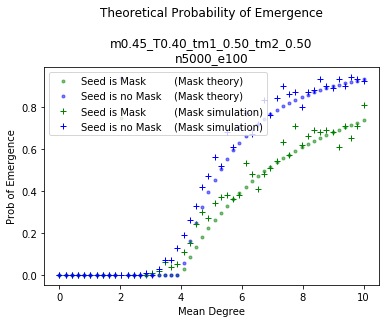

In [177]:
plt.figure()
# plt.plot(mean_degree_list, pe_list, 'yo')
# plt.plot(mean_degree_list, np.array(pe_0_list_m) +  np.array(pe_1_list_m), 'ro', alpha = 0.5)
plt.plot(mean_degree_list, np.array(pe_list0_mask), 'g.', alpha = 0.5)
plt.plot(mean_degree_list, np.array(pe_list1_mask), 'b.', alpha = 0.5)

# plt.plot(mean_degree_list, np.array(pe_list0_mu) , 'gx', alpha = 0.5)
# plt.plot(mean_degree_list, np.array(pe_list1_mu) , 'bx', alpha = 0.5)

plt.plot(mean_degree_list, if0, 'g+')
plt.plot(mean_degree_list, if1, 'b+')
# plt.plot(mean_degree_list, np.array(pe_1_list_m) , 'b.', alpha = 0.5)
# plt.plot(mean_degree_list, sim_mask_pe1, 'bp', alpha = 0.5)
# plt.plot(mean_degree_list, np.array(pe_1_list_m) , 'r^')
# plt.plot(mean_degree_list, np.array(pe_0_list) + np.array(pe_1_list) , 'c^', )
# plt.plot(mean_degree_list, np.array(pe_0_list) , 'm+', )
# plt.plot(mean_degree_list, np.array(pe_1_list) , 'y+', )
# plt.plot(mean_degree_list, sim_mu_pe1 , 'ro', alpha = 0.5)
# plt.plot(mean_degree_list, np.array(pe_1_list) , 'yo')

plt.xlabel("Mean Degree")
plt.ylabel("Prob of Emergence")
title = "Theoretical Prob of Emergence"
plt.legend([
            "Seed is Mask         (Mask theory)",
            "Seed is no Mask    (Mask theory)", 
    
           "Seed is Mask         (Mask simulation)",
            "Seed is no Mask    (Mask simulation)", 
            
#             "Seed is Strain-1   (Mask model)",
#             "Seed is Strain-2   (Mutation model)", 
])
#             "Seed is Strain-2(Mutation model simulation)"])

title = "Theoretical Probability of Emergence\n "  + "\n" + para_setting + '\n' + exp_setting
plt.title(title)

# np.save( "PE_0_mask_20.npy", np.array(pe_0_list_m))
# np.save( "PE_1_mask_20.npy", np.array(pe_1_list_m))
# np.save( "PE_0_mu_20.npy", np.array(pe_0_list))
# np.save( "PE_1_mu_20.npy", np.array(pe_1_list))

In [41]:
###### Sep 11 ######

# Mask PE

In [4]:
def PE(i, is_intermediate, E0, E1, T_list, m, mean_degree):
    res = 0
    for k in range(0, max_degree):
        prob_r = poisson.pmf(k, mean_degree)
        
        if is_intermediate: # intermediate q using excess degree distribution
            pb = prob_r * k * 1.0 / mean_degree 
        else:
            pb = prob_r
            
        res += pb * PE_B(i, is_intermediate, k, E0, E1, T_list, m)
    return res

def PE_B(i, is_intermediate, k, E0, E1, T_list, m):
    res = 0
    one_minus_m = 1 - m
    
    if is_intermediate: # intermediate q, powers sum up to k - 1
        n_range = k
    else:               # generation 0, powers sum up to k
        n_range = k + 1
        
    for n in range(n_range):
        pe_bn = PE_BN(i, is_intermediate, n, k, E0, E1, T_list, m)
        res += pe_bn * comb(n_range - 1, n) * (m ** n) * (one_minus_m ** (n_range - 1 - n))
    return res

def PE_BN(i, is_intermediate, n, k, E0, E1, T_list, m):
    T1 = T_list[0]
    T2 = T_list[1]
    T3 = T_list[2]
    T4 = T_list[3]
    
    res = 0 
    
    if i == 0:
        t_mask = T2
        t_no_mask = T1
    else:
        t_mask = T4
        t_no_mask = T3
    
    one_minus_mask = 1 - t_mask
    one_minus_no_mask = 1 - t_no_mask
        
    if is_intermediate:
        k_range = k 
    else:
        k_range = k + 1
        
    for k0 in range(n + 1):
        for k1 in range(k_range - n):
            res += comb(n, k0) * (t_mask ** k0) * (one_minus_mask ** (n - k0)) *\
            comb(k_range - 1 - n, k1) * (t_no_mask ** k1) * (one_minus_no_mask ** (k_range - 1 - n - k1)) *\
            (E0 ** k0) * (E1 ** k1)
            
    return res


def PE_vec(mean_degree, is_intermediate,  T_list, m, E0, E1):
    E0 = PE(0, is_intermediate, E0, E1, T_list, m, mean_degree)
    E1 = PE(1, is_intermediate, E0, E1, T_list, m, mean_degree)
    return np.array([E0, E1])

def func_root(E, mean_degree, T_list, m):
    return PE_vec(mean_degree, True, T_list, m, E[0], E[1]) - np.array(E)

def get_ProbEmergence(mean_degree, nodeN, T_list, m):
    E0, E1 = fsolve(func_root, (0.01, 0.01), args=(mean_degree, T_list, m), xtol=1e-6)    
    return 1 - PE_vec(mean_degree, False,  T_list, m, E0, E1)

pe_0_list_m = []
pe_1_list_m = []
pe_list_m = []

for mean_degree in mean_degree_list:
    print("Mean degree:", mean_degree)
    E_0_1 = get_ProbEmergence(mean_degree, nodeN, T_list, m)
    pe_list_m.append(E_0_1[0] * m + E_0_1[1] * (1 - m))
    pe_0_list_m.append(E_0_1[0])
    pe_1_list_m.append(E_0_1[1])

# Mutation PE

In [ ]:
def obtain_val_r_1(v1, v2, t1, mean_degree):
    val = 0

    for d_r in range(0, max_degree):
        prob_r = poisson.pmf(d_r, mean_degree)
        val += d_r*prob_r*1.0/mean_degree * ((1 - t1 + t1*u_r_11*v1 + t1*u_r_12*v2)**(d_r-1))

    return val

def obtain_val_r_2(v1, v2, t2, mean_degree):
    val = 0

    for d_r in range(0, max_degree):
        prob_r = poisson.pmf(d_r, mean_degree)
        val += d_r*prob_r*1.0/mean_degree * ((1 - t2 + t2*u_r_22*v2 + t2*u_r_21*v1)**(d_r-1))

    return val

def equations(p):
    v1, v2 = p
    val_r_1 = obtain_val_r_1(v1, v2, t_r_1, mean_degree)
    val_r_2 = obtain_val_r_2(v1, v2, t_r_2, mean_degree)

    return (v1 - val_r_1, v2 - val_r_2)


def cascade_prob():
    h_r_1, h_r_2 = fsolve(equations, (0.01, 0.01), xtol=1e-6)

    H_1 = 0
    for d_r in range(0, max_degree):
        prob_r = poisson.pmf(d_r, mean_degree)
        H_1 += prob_r*((1 - t_r_1 + t_r_1*u_r_11*h_r_1 + t_r_1*u_r_12*h_r_2)**d_r)

    H_2 = 0
    for d_r in range(0, max_degree):
        prob_r = poisson.pmf(d_r, mean_degree)
        H_2 += prob_r*((1 - t_r_2 + t_r_2*u_r_22*h_r_2 + t_r_2*u_r_21*h_r_1)**d_r)

    return (1 - H_1, 1 - H_2)

def parse_args(args):
    parser = argparse.ArgumentParser(description = 'Parameters')
    parser.add_argument('-m', type = float, nargs = '+', default = np.arange(1.0, 10.1, 0.1), help='np.linspace(0.001, 48, 200) (default); list of mean degree: you can type 1 3 5')
    parser.add_argument('-t1', type = float, default = 0.2, help='0.5 (default); the transmissibility of strain-1')
    parser.add_argument('-t2', type = float, default = 0.5, help='0.5 (default); the transmissibility of strain-2')
    parser.add_argument('-m1', type = float, default = 0.75, help='0.5 (default); the mutation probability from 1 to 1')
    parser.add_argument('-m2', type = float, default = 0.75, help='0.5 (default); the mutation probability from 2 to 2')
    return parser.parse_args(args)

q_dict, mu_dict = generate_new_transmissibilities_mutation(T_mask1, T_mask2, T, m)

t1 = q_dict['Q1']
t2 = q_dict['Q2']
m1 = mu_dict['mu11']
m2 = mu_dict['mu22']

pe_0_list = []
pe_1_list = []
pe_list = []


for mean_degree in mean_degree_list:
    
    t_r_1 = t1
    t_r_2 = t2
    u_r_11 = m1
    u_r_12 = 1 - u_r_11
    u_r_22 = m2
    u_r_21 = 1 - u_r_22

    transMAT = [[t1,0],[0,t2]]
    mutMat = [[m1,1-m1],[1-m2,m2]]
    a, b = LA.eig(np.dot(transMAT,mutMat))

    s1, s2 = cascade_prob()
    pe_0_list.append(s1)
    pe_1_list.append(s2)
    pe_list.append(s1 + s2)

# Mask theory v.s. Mask simulation

Text(0.5, 1.0, 'Prob of Emergence for Mask Model')

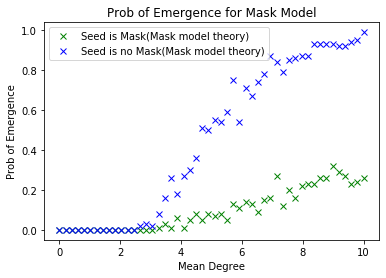

In [95]:
plt.figure()
# plt.plot(mean_degree_list, pe_list, 'yo')
# plt.plot(mean_degree_list, np.array(pe_0_list_m) +  np.array(pe_1_list_m), 'r+', alpha = 0.5)
# plt.plot(mean_degree_list, np.array(pe_0_list_m) , 'g+', alpha = 0.5)
# plt.plot(mean_degree_list, np.array(pe_1_list_m) , 'b+', alpha = 0.5)
# plt.plot(mean_degree_list, sim_mask_pe1, 'bp', alpha = 0.5)
plt.plot(mean_degree_list, np.array(sim_mask_pe1) , 'gx')
plt.plot(mean_degree_list, np.array(sim_mask_pe2) , 'bx')
# plt.plot(mean_degree_list, np.array(pe_0_list) + np.array(pe_1_list) , 'c^', )
# plt.plot(mean_degree_list, np.array(pe_0_list) , 'm^', )
# plt.plot(mean_degree_list, np.array(pe_1_list) , 'y^', )
# plt.plot(mean_degree_list, sim_mu_pe1 , 'ro', alpha = 0.5)
# plt.plot(mean_degree_list, np.array(pe_1_list) , 'yo')

plt.xlabel("Mean Degree")
plt.ylabel("Prob of Emergence")
title = "Prob of Emergence for Mask Model"
plt.legend([
            "Seed is Mask(Mask model theory)",
            "Seed is no Mask(Mask model theory)", 
            "Seed is Mask(Mask model simulation)", 
    "Seed is no Mask(Mask model simulation)", 
            
            ])
#             "Seed is Strain-2(Mutation model simulation)"])
plt.title(title)

Text(0.5, 1.0, 'Prob of Emergence for Mutation Model')

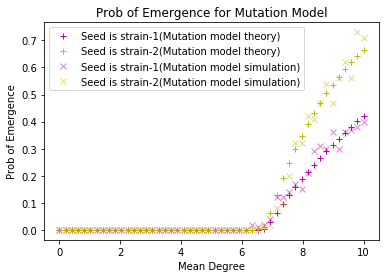

In [46]:
plt.figure()
# plt.plot(mean_degree_list, pe_list, 'yo')
# plt.plot(mean_degree_list, np.array(pe_0_list_m) +  np.array(pe_1_list_m), 'r+', alpha = 0.5)
# plt.plot(mean_degree_list, np.array(pe_0_list_m) , 'g+', alpha = 0.5)
# plt.plot(mean_degree_list, np.array(pe_1_list_m) , 'b+', alpha = 0.5)
# plt.plot(mean_degree_list, sim_mask_pe1, 'bp', alpha = 0.5)
# plt.plot(mean_degree_list, np.array(sim_mask_pe1) , 'bx')
# plt.plot(mean_degree_list, np.array(pe_0_list) + np.array(pe_1_list) , 'c+', )
plt.plot(mean_degree_list, np.array(pe_0_list) , 'm+', )
plt.plot(mean_degree_list, np.array(pe_1_list) , 'y+', )

plt.plot(mean_degree_list, sim_mu_pe1 , 'mx', alpha = 0.5)
plt.plot(mean_degree_list, sim_mu_pe2 , 'yx', alpha = 0.5)
# plt.plot(mean_degree_list, np.array(pe_1_list) , 'yo')

plt.xlabel("Mean Degree")
plt.ylabel("Prob of Emergence")
title = "Prob of Emergence for Mutation Model"
plt.legend([
            "Seed is strain-1(Mutation model theory)",
            "Seed is strain-2(Mutation model theory)", 
            "Seed is strain-1(Mutation model simulation)", 
    "Seed is strain-2(Mutation model simulation)", 
            
            ])
#             "Seed is Strain-2(Mutation model simulation)"])
plt.title(title)